## Overview
This code mimics Excel Solver’s algorithm for linear problems, allowing users to apply custom tweaks to influence the optimal solution.

## 1) Import packages

In [3]:
import pandas as pd
import numpy as np

## 2) Load sample data
New York air quality data

In [5]:
df_air = pd.read_csv('https://data.cityofnewyork.us/api/views/c3uy-2p5r/rows.csv?accessType=DOWNLOAD')
df_air.head()

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Message
0,179772,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,409.0,Southeast Queens,2015,01/01/2015,0.3,NaN
1,179785,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,209.0,Bensonhurst - Bay Ridge,2015,01/01/2015,1.2,NaN
2,178540,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,209.0,Bensonhurst - Bay Ridge,Annual Average 2012,12/01/2011,8.6,NaN
3,178561,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Annual Average 2012,12/01/2011,8.0,NaN
4,823217,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Summer 2022,06/01/2022,6.1,NaN


## 3) Clean data
I will model the fine particles reading for a geo place name using other location's fine particle reading.  The model coefficients will be calculated using the solver algorithm I created

In [7]:
df_selected = df_air[['Name', 'Geo Place Name', 'Time Period', 'Data Value']]

#we will model Fine particles (PM 2.5)
df_selected = df_selected[df_selected['Name']=='Fine particles (PM 2.5)']

#use only data for Annual Average
df_selected = df_selected[['Annual Average' in x for x in df_selected['Time Period']]]

# check how much data we have
print(len(df_selected))

# check time period if there's consistency in the data
print(df_selected['Time Period'].unique())

# get the count for each geo, then filter only for those with complete data
final_geo_list = df_selected['Geo Place Name'].value_counts()
final_geo_list = list(final_geo_list[final_geo_list==final_geo_list.max()].index)
print(final_geo_list)

# filter the selected data to include only those geo loc with complete data
df_selected = df_selected[df_selected['Geo Place Name'].isin(final_geo_list)]

# clean up the time period column, removing the leading 'Annual Average' string
df_selected['Time Period'] = [x.replace('Annual Average ', '') for x in df_selected['Time Period']]

#remove the name column
df_selected = df_selected.drop(['Name'], axis=1)

#show head after cleaning
df_selected.head()

1974
['Annual Average 2012' 'Annual Average 2013' 'Annual Average 2017'
 'Annual Average 2016' 'Annual Average 2021' 'Annual Average 2018'
 'Annual Average 2009' 'Annual Average 2015' 'Annual Average 2011'
 'Annual Average 2020' 'Annual Average 2019' 'Annual Average 2022'
 'Annual Average 2010' 'Annual Average 2014']
['Bensonhurst - Bay Ridge', 'Greenpoint', 'East Flatbush - Flatbush', 'Northeast Bronx', 'Bedford Stuyvesant - Crown Heights', 'Ridgewood - Forest Hills', 'Central Harlem - Morningside Heights', 'West Queens', 'Sunset Park', 'Fordham - Bronx Pk', 'Long Island City - Astoria', 'Southeast Queens', 'Pelham - Throgs Neck', 'Flushing - Clearview', 'Kingsbridge - Riverdale', 'Borough Park', 'East Harlem', 'Washington Heights', 'Canarsie - Flatlands', 'Coney Island - Sheepshead Bay', 'Southwest Queens', 'Rockaways', 'Williamsburg - Bushwick', 'Upper West Side', 'East New York', 'Jamaica', 'Downtown - Heights - Slope']


,Geo Place Name,Time Period,Data Value
2,Bensonhurst - Bay Ridge,2012,8.6
3,Southeast Queens,2012,8.0
10,Bensonhurst - Bay Ridge,2013,8.2
11,Coney Island - Sheepshead Bay,2013,8.1
12,Southeast Queens,2017,6.8


## 4) Pivot Data
make the geo place name features and time period as index

In [18]:
df_pivot = pd.pivot_table(df_selected, values='Data Value', index='Time Period', columns=['Geo Place Name'])
df_pivot.head()

Geo Place Name,Bedford Stuyvesant - Crown Heights,Bensonhurst - Bay Ridge,Borough Park,Canarsie - Flatlands,Central Harlem - Morningside Heights,Coney Island - Sheepshead Bay,Downtown - Heights - Slope,East Flatbush - Flatbush,East Harlem,East New York,...,Pelham - Throgs Neck,Ridgewood - Forest Hills,Rockaways,Southeast Queens,Southwest Queens,Sunset Park,Upper West Side,Washington Heights,West Queens,Williamsburg - Bushwick
Time Period,,,,,,,,,,,,,,,,,,,,,
2009,10.8,9.9,10.3,9.9,11.6,9.6,11.5,10.5,11.6,10.6,...,10.6,10.4,8.8,9.4,10.0,11.0,12.2,11.6,11.0,11.4
2010,9.9,9.2,9.6,9.1,10.6,8.9,10.5,9.8,10.4,9.8,...,9.7,9.5,8.0,8.7,9.2,10.2,11.0,10.7,9.9,10.3
2011,10.3,9.8,10.1,9.6,11.1,9.4,11.1,10.2,11.1,10.1,...,10.5,10.0,8.4,9.2,9.4,10.8,11.5,11.1,10.6,10.9
2012,9.1,8.6,8.9,8.4,10.0,8.3,9.9,9.0,10.0,8.9,...,9.2,8.8,7.4,8.0,8.3,9.6,10.5,9.9,9.5,9.7
2013,8.8,8.2,8.5,8.2,9.7,8.1,9.5,8.6,9.7,8.7,...,8.7,8.5,7.6,7.9,8.1,9.1,10.4,9.5,9.1,9.4


## 5) Split validation/train periods and target/control geos
Split the pivot into 4 groups, train period to train the model using solver algorithm. Validation period to check how model works.  target is the dependent variable while control are the independent variables

In [68]:
df_pivot.index

Index(['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020', '2021', '2022'],
      dtype='object', name='Time Period')

In [70]:
train_period = ['2009', '2010', '2011', '2012', '2013']
validation_period = [x for x in df_pivot.index if x not in train_period]

target_geo = ['East Harlem']
control_geo = [x for x in df_pivot.columns if x not in target_geo]

## 6) Define the pre-processing function
Create the pre-process function taking in 5 inputs: main dataframe, train period, test period, target geo and control geo. The function will then return 4 dataframes: train period/target, train period/control, validation period/target and validation/control

In [73]:
def preprocessing_solver_inputs(
    df: pd.DataFrame,
    target: list,
    control: list,
    train_period: list,
    validation_period: list,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    df_target_train = df[target][df.index.isin(train_period)]
    df_target_validation = df[target][df.index.isin(validation_period)]
    df_control_train = df[control][df.index.isin(train_period)]
    df_control_validation = df[control][df.index.isin(validation_period)]
    
    return df_target_train, df_target_validation, df_control_train, df_control_validation
    

## 7) Define the solver function
Create the solver function taking in train period target and control and then returning the coefficients for control

In [173]:
def solver(
    df_target_train: pd.DataFrame,
    df_control_train: pd.DataFrame,
    max_iterations: int = 5000,
    random_seed: int = 9999,
) -> np.array:

    #convert df_target_train to a single column array
    arr_target_train = pd.DataFrame(df_target_train.sum(axis=1))
    
    np.random.seed(random_seed)

    #initial coefficients
    coefficients = np.ones([len(df_control_train.columns),1])
    tmp_array = np.dot(df_control_train, coefficients)
    tmp_diff = np.subtract(arr_target_train/arr_target_train.mean(), tmp_array/tmp_array.mean())
    squared_residuals = sum(np.sum(tmp_diff**2, axis=1))

    iteration_count = 0
    while iteration_count<max_iterations:
        tmp_coefficients = coefficients.copy()
        coefficient_switch_position = np.random.randint(1, len(tmp_coefficients))
        tmp_coefficients[coefficient_switch_position] = 1 if tmp_coefficients[coefficient_switch_position]==0 else 0
        tmp_array = np.dot(df_control_train,tmp_coefficients)
        tmp_diff = np.subtract(arr_target_train/arr_target_train.mean(), tmp_array/tmp_array.mean())
        tmp_squared_residuals = sum(np.sum(tmp_diff**2, axis=1))

        if tmp_squared_residuals<squared_residuals:
            squared_residuals = tmp_squared_residuals
            coefficients = tmp_coefficients
            iteration_count = 0
        else:
            iteration_count += 1
    
    return coefficients

## 8) Run the functions

In [176]:
df_target_train, df_target_validation, df_control_train, df_control_validation = preprocessing_solver_inputs(
    df_pivot,
    target_geo,
    control_geo,
    train_period,
    validation_period,
)
coefficients = solver(
    df_target_train,
    df_control_train,
)

In [198]:
pred_target = np.dot(df_control_validation, coefficients)
pred_target = pred_target/pred_target.mean()
pred_target

array([[1.24310777],
       [1.20802005],
       [1.07017544],
       [1.03007519],
       [1.00250627],
       [0.95238095],
       [0.82706767],
       [0.88721805],
       [0.77944862]])

<Axes: xlabel='Time Period'>

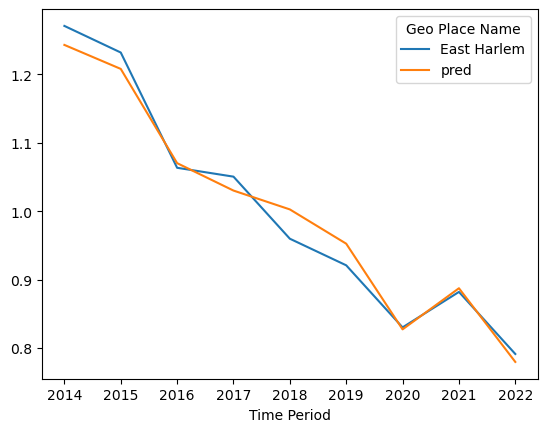

In [196]:
df_final = df_target_validation/df_target_validation.mean()
df_final['pred'] = pred_target
df_final.plot()